In [27]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim as optim
from torch.autograd import Variable
import numpy.random as rand
import numpy as np
import sys
import os
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import



from bnn import BNNBayesbyBackprop, gauss_logpdf
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/d_berman/Documents/Tufts_Masters/Semester_3/Bayesian Deep Learning/BDL_final_project'

## Toy dataset for regression

In [2]:
W = np.array([-10, 10]).reshape(-1, 1)
b = -5
X_train = np.random.uniform(-10,10, (5000, 2))
X_train[:,0] = 0.0
X_train.shape
W.T.shape

eps = 0.0001
W_s = np.array([0.0, 0.3]).reshape(-1, 1)
print(W_s)
b_s = 0.1

print(b_s)

y_train = np.zeros((X_train.shape[0], 1), dtype=float)
for ind, x in enumerate(X_train):
  # y_train[ind] = x @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
  y_train[ind] = x.reshape(1,-1) @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))



print(y_train)

[[0. ]
 [0.3]]
0.1
[[  6.65399419]
 [ -7.64754231]
 [114.28069572]
 ...
 [ 16.75575275]
 [ 92.22654003]
 [-82.40722785]]


(array([671., 641., 617., 639., 681., 630., 711., 333.,  71.,   6.]),
 array([-104.99840991,  -79.19349689,  -53.38858388,  -27.58367086,
          -1.77875784,   24.02615517,   49.83106819,   75.63598121,
         101.44089422,  127.24580724,  153.05072026]),
 <a list of 10 Patch objects>)

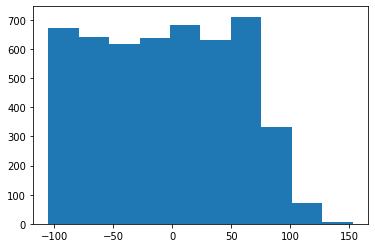

In [3]:
plt.hist(y_train)
# np.exp(10 * 0.01)

compare likelihood of test set given true mean and true variance and true variance + bias

In [4]:
tst = np.empty_like(X_train[:,0])
for ind, x in enumerate(X_train):
  # y_train[ind] = x @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
  tst[ind] = x.reshape(1,-1) @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
tst

print(gauss_logpdf(tst, X_train @ W + b, np.exp(x @ W_s + b_s)).sum())
print(gauss_logpdf(tst, X_train @ W + b, np.exp(x @ W_s + b_s) + 100).sum())

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

Toy dataset for classification 2d

In [452]:
dataset_size = 5000

X_train = np.empty(shape=(dataset_size, 2), dtype=float)
y_train = np.empty(shape=(dataset_size,), dtype=float)

# make first dimension 0 to effectively make it univariate 
# bc current bnn arch only works with multivariate input
# X_train[:int(dataset_size/2),0] = np.random.normal(loc=0,
#                                                    scale=1,
#                                                    size=(int(dataset_size/2),))
# X_train[:int(dataset_size/2), 1] = np.random.normal(loc=0, 
#                                                     scale=1, 
#                                                     size=(int(dataset_size/2),))

scale = 1

X_train[:int(dataset_size/2), 0] = np.random.uniform(2 * scale, 12 * scale, 
                                                    size=(int(dataset_size/2),))
X_train[:int(dataset_size/2), 1] = np.random.uniform(7.5* scale, 13.5 * scale,
                                                   size=(int(dataset_size/2),))


y_train[:int(dataset_size/2)] = 0

X_train[int(dataset_size/2):,0] = np.random.uniform(2 * scale, 12 * scale,
                                                   size=(int(dataset_size/2),))
X_train[int(dataset_size/2):, 1] = np.random.uniform(0.5 * scale, 6.5 * scale,
                                                    size=(int(dataset_size/2),))
y_train[int(dataset_size/2):] = 1

# shuffle order
perm = np.random.permutation(dataset_size)
X_train = X_train[perm]
y_train = y_train[perm]

In [453]:
A = np.array([[1, 1],
              [1, 0]])
X_train = X_train @ A

/anaconda3/envs/Pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


sklearn logistic regression accuracy is: 1.0


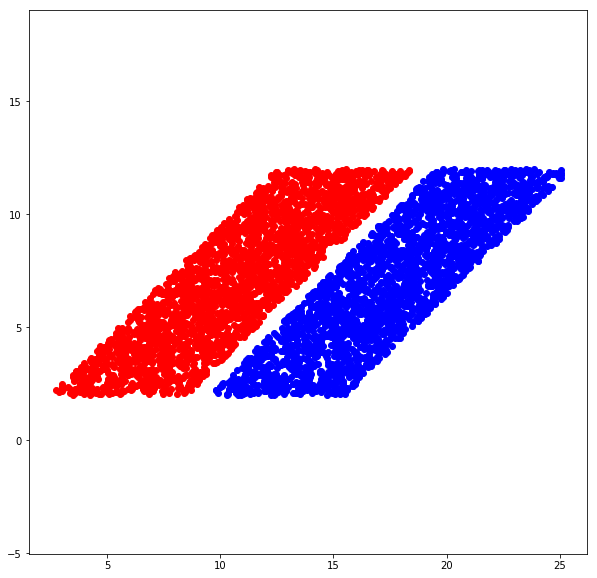

In [454]:
def plane(x1, x2, w1, b):
    return w1[0] * x1 + w1[1] * x2 + b
    

w1 = np.array([[0,0]]).T
w2 = np.array([[0,0]]).T
W_full = np.hstack((w1, w2))
b = 0

x = y = np.arange(-8.0, 8.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = plane(X, Y, w1, b)
# print("X shape", zs.shape)

# Z = zs.reshape(X.shape)

# ax.plot_surface(X, Y, Z)

# x_line = np.random.uniform(-8, 8, (100, 2))
#  = 
# print(w1.T.shape)
# y = w1.T @ x + b
# y = y.flatten()
# plt.plot(x1, x2)
# plt.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='red', alpha=0.2)
# plt.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='blue', alpha=0.2)
# plt.ylim((-10, 10))


fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(311, projection='3d')       
ax = fig.add_subplot(111)   

# ax.plot_wireframe(X, Y, zs, color='grey', alpha = 0.7)
ax.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='blue')
ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='red')
ax.axis('equal')
# ax.set_ylim(-6, 6)
fig.show()
# print("------")                                                        
# print(x_line[:,0].shape)                                                   
# print(x_line[:,1].shape)                                                   
# print(y.shape)                                                        
# print("------")


# ax.scatter(X1_train_grd, X2_train_grd, alpha=0.5)

# ax.plot()
# ax.set_xlabel('X_train[:,0]')                                          
# ax.set_ylabel('X_train[:,1]')                                          
# ax.set_zlabel('output[:,1] (Standard Deviation)')                      
# fig.show()
# plt.show()

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('sklearn logistic regression accuracy is:', lr.score(X_train, y_train))

In [455]:
np.log(0.1)

-2.3025850929940455

In [456]:
for i, row_i in enumerate(X_train):
    X_train[i, 1] = X_train[i, 1] + np.random.normal(loc=0, scale= np.exp(0.08 * X_train[i, 0]))

/anaconda3/envs/Pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/Pytorch/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


sklearn logistic regression accuracy is: 0.89


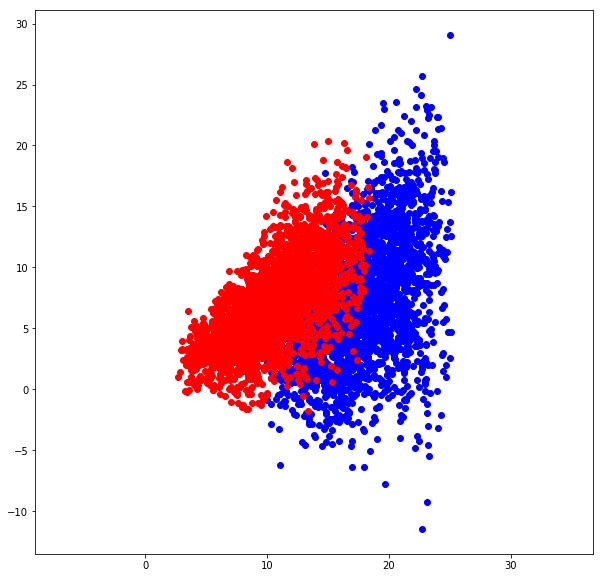

In [457]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('sklearn logistic regression accuracy is:', lr.score(X_train, y_train))

fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(311, projection='3d')       
ax = fig.add_subplot(111)   

# ax.plot_wireframe(X, Y, zs, color='grey', alpha = 0.7)
ax.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='blue')
ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='red')
ax.axis('equal')
# ax.set_ylim(-6, 6)
fig.show()

Toy dataset for classification 1d

In [60]:
dataset_size = 5000

X_train = np.empty(shape=(dataset_size, 2), dtype=float)
y_train = np.empty(shape=(dataset_size,), dtype=float)

# make first dimension 0 to effectively make it univariate 
# bc current bnn arch only works with multivariate input
X_train[:int(dataset_size/2), 0] = 0
X_train[:int(dataset_size/2), 1] = np.random.normal(loc=2,
                                                 scale=1,
                                                 size=(int(dataset_size/2),))
y_train[:int(dataset_size/2)] = 0



X_train[int(dataset_size/2):, 0] = 0
X_train[int(dataset_size/2):, 1] = np.random.normal(loc=10,
                                                   scale=1,
                                                   size=(int(dataset_size/2),))
y_train[int(dataset_size/2):] = 1

# shuffle order
perm = np.random.permutation(dataset_size)
X_train = X_train[perm]
y_train = y_train[perm]

In [61]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

/anaconda3/envs/Pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.0

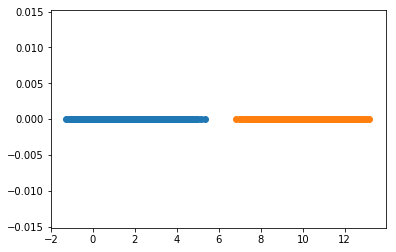

In [62]:
# a separating line!
# x1 = np.linspace(-2, 14, 20)
# y = x1 * 1 - 8.5

plt.scatter(X_train[y_train == 0, 1], [0]*int(X_train.shape[0]/2))
plt.scatter(X_train[y_train == 1, 1], [0]*int(X_train.shape[0]/2))
# plt.plot(x1, y)

In [ ]:
# W_full
# W
# preset_preds.shape
# print('MAE of BNN with q mean == true weights: ', np.mean(np.abs(preset_preds - y_train.flatten())))
# print('acc of BNN with q mean == true weights: ', np.mean((preset_preds == y_train.flatten()).astype(int)))
# print('\n')
# print(preset_preds[1], y_train[1])
# bnn_preset.model.l1.W_log_s_DO
# bnn_preset.model.l1.b_log_s_O
# bnn_preset.MC_elbo(torch.Tensor(X_train), torch.Tensor(y_train), 9, 10, 100).detach().numpy()

# plt.title("line with {} as slope".format(w))
# plt.plot(x1, x2)
# plt.scatter(X_train1[y_train1 == 0,0], X_train1[y_train1 == 0,1], c='red', alpha=0.2)
# plt.scatter(X_train1[y_train1 == 1,0], X_train1[y_train1 == 1,1], c='blue', alpha=0.2)
# plt.ylim((-10, 10))

# ax = fig.add_subplot(311, projection='3d')                             
# print("------")                                                        
# print(x1[:,0].shape)                                                   
# print(x1[:,1].shape)                                                   
# print(y1.shape)                                                        
# print("------")                                                        
# ax.plot_surface(x1[0,1], x1[:,1], y1)                                       
# ax.set_xlabel('X_train[:,0]')                                          
# ax.set_ylabel('X_train[:,1]')                                          
# ax.set_zlabel('output[:,1] (Standard Deviation)')                      
# fig.show()
# plt.show()



## test ELBO as slope of line changes

[[0. 0.]
 [1. 0.]]
[[0.]
 [1.]]
X_int 21.162403

used_b is -20.054132
used_w is  0.94763017

grads w1  tensor([-6.7961e-03, -6.9137e+03])
grad b  tensor(-695.3595)
Accuracy with -20 as bias:  50.0 %
likelihood -38209.665
X_int 20.216524

used_b is -18.58039
used_w is  0.9190695

grads w1  tensor([ 3.0592e-03, -1.0214e+04])
grad b  tensor(-1023.5146)
Accuracy with -19 as bias:  50.0 %
likelihood -37333.1875
X_int 16.733711

used_b is -17.609013
used_w is  1.0523076

grads w1  tensor([-8.2046e-03, -1.4813e+04])
grad b  tensor(-1454.5852)
Accuracy with -18 as bias:  50.0 %
likelihood -36397.1075
X_int 16.37387

used_b is -16.843601
used_w is  1.0286878

grads w1  tensor([ 2.8262e-03, -1.7274e+04])
grad b  tensor(-1709.2228)
Accuracy with -17 as bias:  50.0 %
likelihood -34417.4125
X_int 16.305536

used_b is -16.17023
used_w is  0.99170184

grads w1  tensor([-7.5810e-03, -2.3520e+04])
grad b  tensor(-2310.4102)
Accuracy with -16 as bias:  50.0 %
likelihood -33066.4475
X_int 17.553799

used

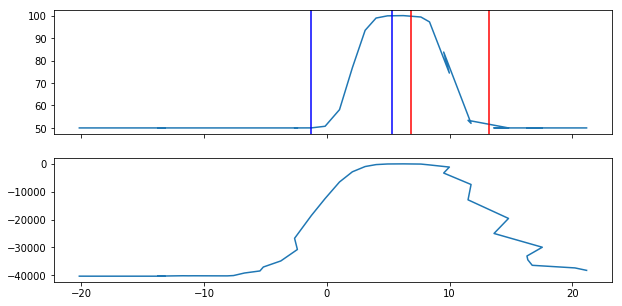

In [67]:
def plane(x1, x2, w1, b):
    return w1[0] * x1 + w1[1] * x2 + b

# for regression toy set
# W_full = np.hstack((W, W_s))
# W_full

# b_full = np.hstack((b, b_s))
# b_full[1] = 2.0

# for 3d
# w1 = np.array([[0.0,1.0]]).T
# w2 = np.array([[0.0,0.0]]).T
# W_full = np.hstack((w1, w2))

# x1 = x2 = np.arange(-8.0, 8.0, 0.05)
# X1, X2 = np.meshgrid(x, y)
# b = 0
# Z = plane(X1, X2, w1, b)


w1 = np.array([[0.0,1.0]]).T
w2 = np.array([[0.0,0.0]]).T
W_full = np.hstack((w1, w2))
print(W_full)
print(w1)
# x1 = x2 = np.arange(-8.0, 8.0, 0.05)
# X1, X2 = np.meshgrid(x, y)
# b = 0
# Z = plane(X1, X2, w1, b)
mc_samples = [i for 20 * i in range(1, 11)]
bs = [i for i in range(-20, 15)]
used_bs = []
accuracies = []
x_ints = []
likelihoods = []
grad_bs = []
for b in bs:
    b_full = np.array([b,0])
    # b_full[0], b_full[1] = 0,0
    bnn_preset = BNNBayesbyBackprop(prior_mu=0, 
                                    prior_s=0.8, 
                                    linear_regression=True, 
                                    classification=True,
                                    preset={'W_mu': W_full, 'b_mu': b_full},
                                    num_MC_samples=200)
    preset_preds = bnn_preset.model.forward(torch.Tensor(X_train), predict=True).detach().numpy()
    used_b = bnn_preset.model.l1.usedBias[0].detach().numpy()
    used_w = bnn_preset.model.l1.usedWeights[:,0][1].detach().numpy()
    used_bs.append(used_b)
    
    x_intercept = -used_b / used_w
    x_ints.append(x_intercept)
    print('X_int', x_intercept)
    print('\nused_b is', used_b)
    print('used_w is ', used_w)
    
    bnn_preset.MC_elbo(torch.Tensor(X_train), torch.Tensor(y_train), 9, 10, 100).detach().numpy()
    acc = np.mean((preset_preds == y_train.flatten()).astype(int)) * 100
    accuracies.append(acc)
    print('Accuracy with {} as bias: '.format(b), acc, '%')
    
    likelihood = bnn_preset.mean_likelihood
    likelihoods.append(likelihood)
    print('likelihood', likelihood)
    
    grad_bs.append(bnn_preset.gradB)
 
fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True)
ax[0].plot(x_ints, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')

# ax[0].scatter([np.min(X_train[y_train == 1, 1]), np.max(X_train[y_train == 1, 1])], [50,50], c='red')


ax[1].plot(x_ints, likelihoods)
print('class 0 min: ', np.min(X_train[y_train == 0, 1]))
print('class 0 max: ',np.max(X_train[y_train == 0, 1]))
print('class 1 min: ', np.min(X_train[y_train == 1, 1]))
print('class 1 max: ',np.max(X_train[y_train == 1, 1]))



In [ ]:
# nesting subplots in subplots for MC sampling model selection?

fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(3, 3, wspace=0.2, hspace=0.2)

for i in range(9):
    inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    
    
    for j in range(3):
        ax = plt.Subplot(fig, inner[j])
#         t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i,j))
#         t.set_ha('center')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        
fig.show()

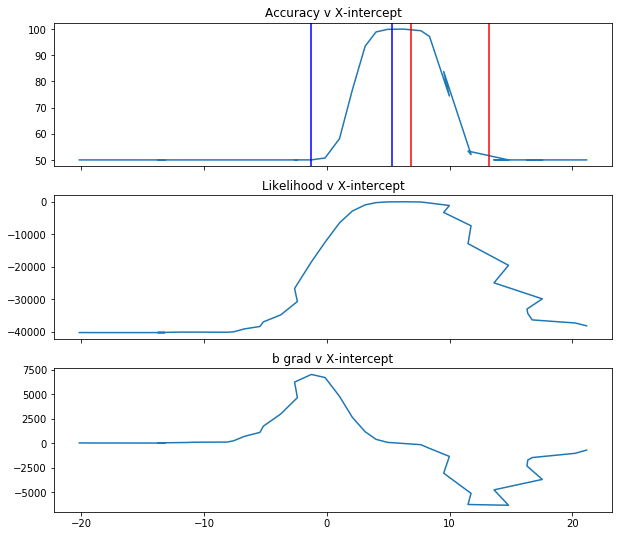

In [68]:


fig, ax = plt.subplots(3, 1, figsize=(10,9), sharex=True)
ax[0].set_title('Accuracy v X-intercept')
ax[0].plot(x_ints, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')
ax[1].set_title('Likelihood v X-intercept')
ax[1].plot(x_ints, likelihoods)

ax[2].set_title('b grad v X-intercept')
ax[2].plot(x_ints, grad_bs)

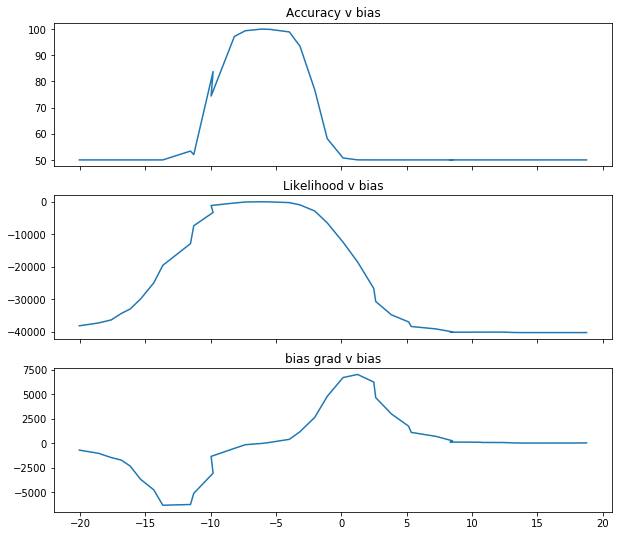

In [70]:
fig, ax = plt.subplots(3, 1, figsize=(10,9), sharex=True)
ax[0].set_title('Accuracy v bias')
ax[0].plot(used_bs, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
# ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
# ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

# ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
# ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')
ax[1].set_title('Likelihood v bias')
ax[1].plot(used_bs, likelihoods)

ax[2].set_title('bias grad v bias')
ax[2].plot(used_bs, grad_bs)

In [9]:
X_train1 = X_train
y_train1 = y_train

accuracies = []
weights = [0.0, 0.1, 0.5, 1.0, 3.0, 5.0, 5.5, 6.0, 7.0, 10.0]
for w in weights:
#     w1 = np.array([0, w])
    W_full[0][0] = w
    print('weights: ', W_full[0])
    bnn_preset = BNNBayesbyBackprop(prior_mu=0, 
                                prior_s=0.8, 
                                linear_regression=True, 
                                classification=True,
                                preset={'W_mu': W_full, 'b_mu': b_full})
    preset_preds = bnn_preset.model.forward(torch.Tensor(X_train1), predict=True).detach().numpy()
    print('ELBO components with {} as slope: \n'.format(w))
    bnn_preset.MC_elbo(torch.Tensor(X_train1), torch.Tensor(y_train1), 9, 10, 100).detach().numpy()
    print('Accuracy with {} as slope: '.format(w), np.mean((preset_preds == y_train1.flatten()).astype(int)) * 100, '%')
    
    Z = plane(X1, X2, W_full[0], b)
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(311, projection='3d') 
    ax.set_title("line with {} as slope".format(w))

    ax.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='blue')
    ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='red')
    ax.plot_wireframe(X1, X2, Z, color='grey', alpha = 0.99)

#     fig.show()
    plt.show()
#     x1 = np.random.uniform(-8, 8, 100)
#     x2 = w * x1

#     plt.title("line with {} as slope".format(w))
#     plt.plot(x1, x2)
#     plt.scatter(X_train1[y_train1 == 0,0], X_train1[y_train1 == 0,1], c='red', alpha=0.2)
#     plt.scatter(X_train1[y_train1 == 1,0], X_train1[y_train1 == 1,1], c='blue', alpha=0.2)
#     plt.ylim((-10, 10))
    

weights:  [0 0]


NameError: name 'b_full' is not defined

In [489]:
# bnn = BNNBayesbyBackprop(prior_mu=0, prior_s=0.8, num_MC_samples=30, linear_regression=True, preset=False, classification=False)
# w1 = np.array([[0.0, 1.0]]).T
# w2 = np.array([[0.0, 0.0]]).T
# W_full = np.hstack((w1, w2))
# b_full = np.array([0,0])
# print(W_full)

# 3865044.5 

bnn = BNNBayesbyBackprop(prior_mu=0.0, prior_s=1.0, num_MC_samples=100, linear_regression=True, preset=False, classification=True)
bnn.fit(X_train, y_train, plot=True, n_epochs=200, learning_rate=1e-1, batch_size=1000)

Data being saved in following file:
logging.csv
tensor([1., 1., 0.,  ..., 1., 1., 1.])
[1 1 1 ... 1 1 1]
true pos:  5000  total real pos:  2500  pred_pos:  5000
Epoch:  0 	Loss:  39281.273 	acc:  0.5 	prec:  1.0 	rec:  2.0
tensor([1., 1., 0.,  ..., 1., 1., 1.])
[1 1 1 ... 1 1 1]
true pos:  5000  total real pos:  2500  pred_pos:  3539
Epoch:  1 	Loss:  37558.457 	acc:  0.6478 	prec:  1.4128284826222097 	rec:  2.0
tensor([1., 1., 0.,  ..., 1., 1., 1.])
[1 1 1 ... 1 1 1]
true pos:  5000  total real pos:  2500  pred_pos:  4021
Epoch:  2 	Loss:  34641.758 	acc:  0.653 	prec:  1.2434717731907485 	rec:  2.0
tensor([1., 1., 0.,  ..., 1., 1., 1.])
[1 1 1 ... 1 1 1]
true pos:  5000  total real pos:  2500  pred_pos:  2718
Epoch:  3 	Loss:  31724.918 	acc:  0.7364 	prec:  1.839587932303164 	rec:  2.0
tensor([1., 1., 0.,  ..., 1., 1., 1.])
[1 1 1 ... 1 1 1]
true pos:  5000  total real pos:  2500  pred_pos:  1309
Epoch:  4 	Loss:  25009.664 	acc:  0.6738 	prec:  3.819709702062643 	rec:  2.0


KeyboardInterrupt: 

In [468]:

df = pd.read_csv("logging.csv")
df
#df.drop(['w2_1', 'w2_2', 'w2_1_grad', 'w2_2_grad', 'b_2', 'b_2_grad'], axis=1, inplace=True)


# df['change_mean_likelihood'] = df['mean_likelihood'].abs() - df['mean_likelihood'].shift(-1).abs()
# df[['w1_1', 'w1_1_grad', 'w1_2', 'w1_2_grad', 'w2_1_grad','w2_1', 'w2_2', 
#        'w2_2_grad', 'b_1', 'b_1_grad', 'b_2', 'b_2_grad', 'log_prior',
#        'log_posterior', 'mean_likelihood', 'change_mean_likelihood']]
# df['mean_likelihood'].abs()
# X = list(range(df.shape[0]))
# plt.plot(X, df['b_1_grad'])
# plt.plot(X, np.zeros(df.shape[0]))
# plt.show()

# plt.plot(X, df['b_1'])
# plt.show()


# print(df.columns)
# plt.plot(df['reg'], c='blue')
# plt.plot(df['b_2_grad'], c='green')
# plt.show()
# plt.plot(df['mean_likelihood'])
# plt.show()
# plt.plot(df['b_2'])
# plt.show()
# plt.plot(df['reg'])
# plt.ylim(2000, -2000)
# plt.show()
df

,,,,,,,,,,,,,,,,,,w1_1,w1_2,w2_1,w2_2,w1_1_grad,w1_2_grad,w2_1_grad,w2_2_grad,b_1,b_2,b_1_grad,b_2_grad,log_prior,log_posterior,mean_likelihood,reg
0.113351,0.000013,-0.117005,0.029153,-0.093777,0.031443,0.111681,0.008954,-0.053444,0.004346,-24.316315,346.906900,-49.407833,81.568054,54.048054,157.370620,-15.039565,38.639687,63.268540,146.935420,0.124267,-0.064913,-0.023322,-0.016702,0.071915,23.981491,0.595224,12.149637,10.081287,19.351685,-83.070898,-80.724712,-8029.954375,-2302.582188
0.113026,0.000010,-0.117354,0.029477,-0.094273,0.030943,0.112087,0.008536,-0.053251,0.003935,183.026730,-308.322420,733.154700,-603.858900,44.742460,171.217990,-136.421190,254.794160,-133.944610,34.284355,0.123766,-0.064549,-0.023759,-0.016497,0.071520,25.800154,-25.077927,53.258545,-22.846262,3.474626,-82.572168,-80.495103,-7981.570625,-2302.582188
0.112631,-0.000180,-0.117720,0.029803,-0.094714,0.030445,0.112055,0.008110,-0.053000,0.003499,406.505800,338.073550,283.365940,-167.827440,169.417500,250.930040,156.027010,115.289680,-54.911938,256.589140,0.123317,-0.064567,-0.024218,-0.016264,0.071083,79.001050,24.021780,37.234493,-6.393527,28.735071,-83.322412,-81.105415,-7680.925000,-2302.582188
0.112522,-0.000242,-0.118068,0.029964,-0.095086,0.030308,0.112199,0.007662,-0.053065,0.003119,-295.419400,-179.799240,145.797000,211.460620,6.783471,-272.588600,-144.704480,171.073840,162.513760,24.075705,0.123035,-0.064399,-0.024688,-0.016281,0.070801,-22.631191,-27.249916,36.762810,18.759424,-8.068735,-82.188984,-80.138354,-7854.774375,-2302.582188
0.112265,-0.000312,-0.118270,0.029913,-0.095492,0.030088,0.112140,0.007409,-0.053269,0.002740,529.140900,41.285610,-244.652740,487.552370,97.265580,203.082120,180.342900,-130.168490,163.604680,78.666250,0.122707,-0.064282,-0.024967,-0.016478,0.070473,38.750336,3.952260,-27.742450,29.940536,15.443745,-83.195713,-81.067314,-7924.110625,-2302.582188
0.112018,-0.000455,-0.118450,0.029793,-0.095501,0.029839,0.111953,0.007192,-0.053525,0.002593,75.981560,207.634110,20.714040,256.653140,-266.047100,122.965706,208.335560,0.007572,104.323235,-185.294390,0.122404,-0.064386,-0.025266,-0.016712,0.070310,8.009199,41.204020,21.098610,12.361988,-15.769210,-83.088672,-81.061460,-7832.800625,-2302.582188
0.111699,-0.000647,-0.118631,0.029646,-0.095532,0.029523,0.111700,0.006921,-0.053795,0.002499,494.535030,188.623750,81.673420,150.333100,31.309921,296.818360,168.124180,140.744060,60.744232,-46.267643,0.122064,-0.064488,-0.025524,-0.016993,0.070206,39.355010,2.541938,-0.685990,16.828045,-6.240723,-83.183477,-80.887603,-7768.957500,-2302.582188
0.111356,-0.000910,-0.118794,0.029718,-0.095537,0.029183,0.111375,0.006745,-0.053699,0.002372,282.280880,338.523300,9.797379,-801.018000,-31.176395,180.993620,283.688020,-88.527700,-527.881300,67.661800,0.121722,-0.064724,-0.025731,-0.016895,0.070054,21.178736,57.821630,-6.830553,-87.618935,11.205880,-82.223457,-80.295239,-7911.012500,-2302.582188
0.111114,-0.001170,-0.118966,0.029745,-0.095613,0.028902,0.111076,0.006552,-0.053653,0.002225,-214.523600,88.902360,100.998820,177.606170,103.872370,-48.582620,21.942560,64.161560,97.051160,53.926155,0.121426,-0.064935,-0.025941,-0.016849,0.069859,-3.703342,0.660799,9.356784,16.251745,12.111877,-82.933613,-80.847646,-7892.067500,-2302.582188
0.110890,-0.001364,-0.119162,0.029840,-0.095849,0.028658,0.110809,0.006302,-0.053533,0.002057,29.708670,-113.164100,157.006680,-368.066220,501.297300,-18.035020,0.089405,157.082180,-220.230480,59.780876,0.121170,-0.065088,-0.026181,-0.016734,0.069578,-3.171258,-11.720093,20.499626,-32.850310,31.462904,-82.488838,-80.451445,-7928.339375,-2302.582188


torch.Size([150, 2])


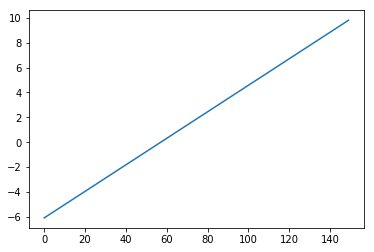

In [127]:
#X_sample = np.vstack([np.zeros(21), np.array(list(range(-10,11)))]).T

X_sample = np.arange(-5, 10, .1)
X_sample = torch.tensor(
                    np.vstack([np.zeros(len(X_sample)), X_sample]).T,
                    dtype=torch.float32)

print(X_sample.shape)


sample_pred = bnn.model.forward(X_sample).detach().numpy()


plt.plot(list(range(len(X_sample))),
         sample_pred[:,1])
plt.show()

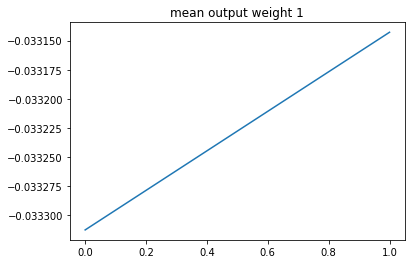

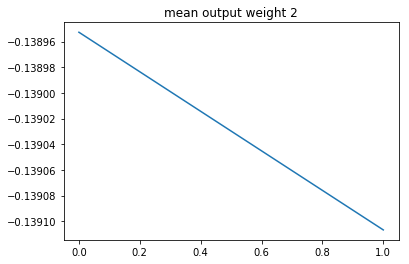

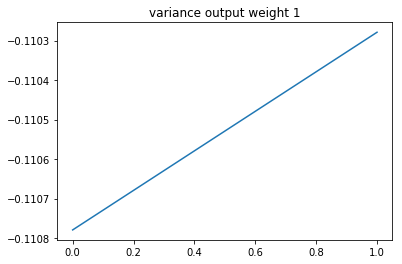

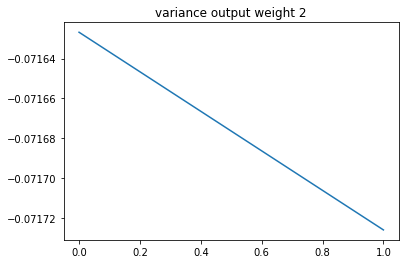

In [23]:
from graph_utils import *

df = pd.read_csv("1575743846.csv")


"""
w1_1,w1_2,w2_1,w2_2,
w1_1_grad,w1_2_grad,w2_1_grad,w2_2_grad,
b_1,b_2,
b_1_grad,b_2_grad
"""

graphCols(df, cols=['w1_1', 'w1_2', 'w2_1', 'w2_2'], ylabel='y', plotDim1=4, plotDim2=4)



In [ ]:
a = torch.normal(torch.tensor([0.0]*5), torch.tensor([5.0]*5))
print(a)

sig = nn.Sigmoid()
sig(a) > 0.5

bnn.likelihood_est(torch.tensor([0.0]*5), a, 0.1)

In [ ]:
for _ in range(10):
    pred1 = X_train @ W + b 
    pred2 = X_train @ W + b + np.random.normal(loc=0, scale=np.exp(X_train @ W_s + b_s))
    mae1 = np.mean(np.abs(pred1 - y_train))
    mae2 = np.mean(np.abs(pred2 - y_train))
    print("MAE 1: ", mae1, "MAE 2:", mae2)

In [ ]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

final_pred = bnn.model.forward(torch.Tensor(X_train))
print(final_pred[:5,0])


pred_std = torch.exp(final_pred[:,1])

print(pred_std)
print(X_train)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(311, projection='3d')

sparse_cap = int(len(X_train) / 10)

ax.scatter(X_train[:sparse_cap,0], X_train[:sparse_cap,1], pred_std[:sparse_cap].detach().numpy())
ax.set_xlabel('X_train[:,0]')
ax.set_ylabel('X_train[:,1]')
ax.set_zlabel('output[:,1] (Standard Deviation)')



# 2D Plot:
ax_2d_x = fig.add_subplot(312)
ax_2d_x.scatter(X_train[:,0], pred_std.detach().numpy())
ax_2d_x.set_xlabel('X_train[:,0]')
ax_2d_x.set_ylabel('output[:,1] (Standard Deviation)')


ax_2d_y = fig.add_subplot(313)
ax_2d_y.scatter(X_train[:,1], pred_std.detach().numpy())
ax_2d_y.set_xlabel('X_train[:,1]')
ax_2d_y.set_ylabel('output[:,1] (Standard Deviation)')



In [ ]:
np.zeros(40)
X_sample = np.vstack([np.zeros(21), np.array(list(range(-10,11)))]).T
X_sample = torch.tensor(np.array(X_sample), dtype=torch.float32)


predictions = bnn.model.forward(torch.Tensor(X_train))

sample_pred = bnn.model.forward(X_sample)

y_pred = sample_pred[:,0].detach().numpy()
std_pred = torch.exp(sample_pred[:,1]).detach().numpy()
log_s_pred = sample_pred[:,1].detach().numpy()

print(std_pred)

# Sample variance to add to the y predictions
std_array = []
for scale in std_pred:
  std_array.append(np.random.normal(loc=0, scale=np.exp(scale)))
std_array = np.array((std_array))



"""
plt.scatter(X_train[:,0], y_pred + std_array, alpha=.1, label='predicted')
plt.scatter(X_train[:,0], y_train, alpha=.1, label='real')
plt.title("Y hat and Y values across X1")
plt.legend()
plt.savefig("x1_y.png")
"""


plt.show()

# For constant std dev#
#std_pred = 10 * torch.ones([y_pred.shape[0]], dtype=torch.float64)
# For constant std dev#

#plt.scatter(X_train[:,1], y_pred + std_array, alpha=.1, label='predicted')
#plt.scatter(X_sample[:,1], y_pred, alpha=.1, label='predicted')
plt.errorbar(X_sample[:,1], y_pred, yerr=(std_pred), fmt='o', label='predicted')
plt.scatter(X_train[:,1], y_train, alpha=.1, c='C1', label='real')
plt.ylabel("Y")
plt.xlabel("X")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.title("Predicted and real Y values vs X")
plt.legend()
plt.savefig("x_y1.png")
plt.show()



#stds = []
#Xs = list(range(-10, 11))
#for x in Xs:
#    stds.append(x + b_s)

#std_pred = predictions[:,1].detach().numpy()

real_std = []
for x in range(-10, 11):
    real_std.append(np.exp(np.array([0, x] @ W_s + b_s)))
print(real_std)
# plt.plot(list(range(-10,11)), list(range(0, 21)), c='C3', label='real')
plt.plot(list(range(-10,11)), real_std, c='C3', label='real')
plt.plot(X_sample[:,1], (std_pred), label='predicted')
plt.title("Standard Deviation versus X value")
plt.ylabel("standard deviation")
plt.xlabel("X")
plt.legend()
plt.savefig("std1.png")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.show()

In [ ]:
print(torch.exp(bnn.model.l1.W_log_s_DO))

In [ ]:

plt.plot([i for i in range(100)], loss_by_epoch)

In [ ]:
a = torch.tensor([3,3,3])
b = torch.tensor([5,5,3])
a == b